In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import pandas as pd
import numpy as np
import scattertext as st
from wordcloud import WordCloud, STOPWORDS
import scattertext as st
import nltk
import warnings
warnings.filterwarnings('ignore')

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet

In [3]:
PS = PorterStemmer()

In [4]:
import math
from sklearn.neighbors import NearestNeighbors

In [5]:
from fuzzywuzzy import fuzz
from sklearn.metrics.pairwise import cosine_similarity

## Constant Variable

In [6]:
data_path = 'liquor_data_new.csv'

## Data Exploration

In [7]:
def load_data(data_path):
    return pd.read_csv(data_path, encoding='utf-8', sep='\t')

In [16]:
df_initial = load_data(data_path)
df_initial.f6.max()

0.8703716993331909

In [17]:
tab_infor = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
tab_infor = tab_infor.append(pd.DataFrame(df_initial.isnull().sum(axis=0)).T.rename(index={0: 'null values'}))
tab_infor = tab_infor.append(pd.DataFrame(df_initial.isnull().sum(axis=0) * 100 / df_initial.shape[0]).T.rename(index={0: 'null % values'}))
tab_infor

,name,intl_name,brand_name,brand_intl_name,year_month,rank,score,f1,f2,f3,f4,f5,f6,flavour_tags,checkin_count,pictures,similar_brands,id,similar_brand_taste
column type,object,object,object,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,object,int64,object,object,int64,object
null values,0,144,0,0,0,0,0,326,326,326,326,326,326,19,0,1,126,0,326
null % values,0,13.4328,0,0,0,0,0,30.4104,30.4104,30.4104,30.4104,30.4104,30.4104,1.77239,0,0.0932836,11.7537,0,30.4104


In [18]:
key_tags = set()

for tags in df_initial['flavour_tags']:
    if tags is None or isinstance(tags, float): continue
    key_tags = key_tags.union(tags.split('|'))

In [19]:
key_tags = [s for s in key_tags if s]

In [20]:
def count_words(df, colone):
    key_counts = dict()
    key_occurence = []
    
    for s in key_tags:
        key_counts[s] = 0
    
    for row in df[colone]:
        if row is None or isinstance(row, float): continue
        for s in row.split('|'):
            if s in key_counts.keys(): key_counts[s] += 1
            else: key_counts[s] = 0
    
    for (k, v) in key_counts.items():
        key_occurence.append([k, v])
    key_occurence.sort(key = lambda x: x[1], reverse=True)
    
    return key_counts, key_occurence

In [21]:
key_counts, key_occurence = count_words(df_initial, 'flavour_tags')

## Duplicate values

In [14]:
df_duplicate = df_initial[df_initial['name'].map(df_initial.name.value_counts() > 1)]

In [15]:
def get_infor(gr):
    return gr.brand_name, gr.brand_name.count()

## Data preprocessing

In [16]:
def keytag_inventory(df, column='flavour_tags'):
    key_root = dict()
    key_select = dict()
    category_key = []
    
    for row in df[column]:
        if row is None or isinstance(row, float): continue
        
        for s in row.split('|'):
            if len(s) == 0: continue
            racine = PS.stem(s)
            
            if racine in key_root.keys():
                key_root[racine].add(s)
            else:
                key_root[racine] = {s}

    for s in key_root.keys():
        min_length = 1000
        
        for v in key_root[s]:
            if len(key_root[s]) > 1:
                if len(v) < min_length:
                    min_length = len(v)
                    ref = v
            else:
                ref = v
        category_key.append(ref)
        key_select[s] = ref
    
    return key_select, key_root, category_key

In [17]:
key_select, key_root, category_key = keytag_inventory(df_initial)

In [18]:
def keytag_replacement(df, key_select, root=False, column='flavour_tags'):
    df_new = df.copy()
    
    for index, row in df_new.iterrows():
        flavour_tags = row[column]
        
        if pd.isnull(flavour_tags): continue
        row_data = []
        for s in flavour_tags.split('|'):
            racine = PS.stem(s) if root else s
            
            if racine is key_select.keys():
                row_data.append(key_select[racine])
            else:
                row_data.append(s)
                
        df_new.at[index, column] = '|'.join(row_data)
    return df_new

In [19]:
df_keywords_cleaned = keytag_replacement(df_initial, key_select, root=True)

In [20]:
key_counts, key_occurence = count_words(df_initial, 'flavour_tags')

## Finding synonyms

In [21]:
df_initial.flavour_tags.values[1]

'|辛口|蜜|スッキリ|力強い|旨味|ゴクゴク|洋梨|若い|じっくり|薄い|円やか|ちびちび|酸味|深み|苦味|まろやか|複雑|まったり|しっかり|柔らかい'

In [22]:
df_keywords_cleaned.flavour_tags.values[1]

'|辛口|蜜|スッキリ|力強い|旨味|ゴクゴク|洋梨|若い|じっくり|薄い|円やか|ちびちび|酸味|深み|苦味|まろやか|複雑|まったり|しっかり|柔らかい'

## Filling missing values

In [23]:
brand_nan = []

In [24]:
def remove_nan_similar_brands(df):
    brand_nan = []
    df_new = df.copy()
    
    for idx, row in df_new.iterrows():
        similar_brand_taste = row.similar_brand_taste
        if pd.isnull(similar_brand_taste): continue
        
        similar_brand_taste = similar_brand_taste.split("|")
        for b_name in similar_brand_taste:
            record = df_new[df_new.name == b_name]
            f1 = record.f1.values
            
            if len(f1) == 0 or pd.isnull(f1[0]):
                if b_name not in brand_nan: brand_nan.append(b_name)

    return brand_nan

In [25]:
brand_nan = remove_nan_similar_brands(df_keywords_cleaned)

In [26]:
len(brand_nan)

125

In [27]:
def replace_similar_brand(df, brand_nan):
    df_new = df.copy()
    
    for idx, row in df_new.iterrows():
        similar_brand_taste = row.similar_brand_taste
        if pd.isnull(similar_brand_taste): continue
            
        similar_brand_taste = similar_brand_taste.split("|")
        replacent = []
        
        for b_name in similar_brand_taste:
            if b_name not in brand_nan: 
                replacent.append(b_name)
        
        df_new.at[idx, "similar_brand_taste"] = "|".join(replacent)
    
    return df_new

In [28]:
df_remove_nan_brands = replace_similar_brand(df_keywords_cleaned, brand_nan)

In [29]:
def sequel(string_1, string_2):
#     print("string_1", string_1)
#     print("string_2", string_2)
    if pd.isnull(string_1): return False
    return (fuzz.ratio(string_1, string_2) >= 70 or fuzz.token_sort_ratio(string_1, string_2) >= 70)

In [30]:
df_missing = pd.DataFrame(df_keywords_cleaned.isnull().sum(axis=0)).reset_index()
df_missing.columns = ['column_name', 'value_null']
df_missing['filling_factor'] = (df_keywords_cleaned.shape[0] - df_missing['value_null'])/df_keywords_cleaned.shape[0] * 100

In [31]:
df_missing

,column_name,value_null,filling_factor
0,name,0,100.000000
1,intl_name,144,86.567164
2,brand_name,0,100.000000
3,brand_intl_name,0,100.000000
4,year_month,0,100.000000
5,rank,0,100.000000
6,score,0,100.000000
7,f1,326,69.589552
8,f2,326,69.589552
9,f3,326,69.589552


In [32]:
df_duplicate_index = df_duplicate.index
df_duplicate_index

Int64Index([   8,   15,   66,   71,   81,   83,   84,   85,   89,   95,  115,
             121,  122,  132,  169,  187,  220,  243,  248,  375,  382,  395,
             441,  450,  466,  480,  483,  485,  487,  519,  521,  535,  536,
             579,  591,  616,  619,  627,  628,  636,  640,  817,  824,  845,
             852,  855,  860,  862,  863,  870,  874,  875,  877,  890,  908,
             911,  916,  935,  948,  992, 1002, 1018],
           dtype='int64')

In [33]:
df_keywords_cleaned[df_keywords_cleaned.f1.notnull() & df_keywords_cleaned.flavour_tags.isnull()].shape

(3, 19)

In [34]:
df_missing_f = df_keywords_cleaned[df_keywords_cleaned.f1.isnull() & df_keywords_cleaned.flavour_tags.notnull()]

In [45]:
df_missing_f

,name,intl_name,brand_name,brand_intl_name,year_month,rank,score,f1,f2,f3,f4,f5,f6,flavour_tags,checkin_count,pictures,similar_brands,id,similar_brand_taste
7,北の勝,Kitanokatsu,北海道,Hokkaido,202001,8,4.024530,NaN,NaN,NaN,NaN,NaN,NaN,|マイルド|フレッシュ|花|豊か|キレ|フルーティ|ガス|スッキリ|軽快|辛口|甘味|バラン...,63,https://s3-ap-northeast-1.amazonaws.com/physal...,墨廼江|加茂錦|繁枡|大信州|土佐しらぎく,1562,NaN
10,大雪乃蔵,Taisetsunokura,北海道,Hokkaido,202001,11,4.011490,NaN,NaN,NaN,NaN,NaN,NaN,|丸み|優しい|スイスイ|辛口|旨味|キリリ|さわやか|フレッシュ|華やか|バランス|常温|...,50,https://s3-ap-northeast-1.amazonaws.com/physal...,若竹|臥龍梅|あさ開|谷川岳|きりんざん,3,NaN
11,風のささやき,Kazenosasayaki,北海道,Hokkaido,202001,12,4.011301,NaN,NaN,NaN,NaN,NaN,NaN,|さらり|優しい|軽快|常温|さっぱり|辛口|旨味|スッキリ|酸味,14,https://s3-ap-northeast-1.amazonaws.com/physal...,NaN,8,NaN
12,十一州,NaN,北海道,Hokkaido,202001,13,4.009420,NaN,NaN,NaN,NaN,NaN,NaN,|昔ながら|控えめ|甘味|穏やか|常温|さっぱり|上品|キリリ|苦味|軽快|余韻|フルーティ...,44,https://s3-ap-northeast-1.amazonaws.com/physal...,松みどり|聖泉|田酒|黎明|豊盃,2309,NaN
13,まる田,Maruta,北海道,Hokkaido,202001,14,4.009420,NaN,NaN,NaN,NaN,NaN,NaN,|あっさり|コク|薄い|さらり|熱燗|上品|バランス|キレ|常温|濃厚|スッキリ|酸味|しっ...,20,https://s3-ap-northeast-1.amazonaws.com/physal...,湊屋藤助|ん|大七|天領|義侠,1275,NaN
16,宝川,Takaragawa,北海道,Hokkaido,202001,17,4.007886,NaN,NaN,NaN,NaN,NaN,NaN,|芳香|洋梨|派手|力強い|キリリ|心地よい|優しい|ワイン|旨味|キレ|しっかり|スッキリ...,33,https://s3-ap-northeast-1.amazonaws.com/physal...,田むら|蒼田|佐藤卯兵衛|千代の園|浪乃音,4,NaN
17,田中酒造,NaN,北海道,Hokkaido,202001,18,4.007886,NaN,NaN,NaN,NaN,NaN,NaN,|昔ながら|バランス|フルーティ,8,https://s3-ap-northeast-1.amazonaws.com/physal...,NaN,1848,NaN
27,亀吉,Kamekichi,青森県,Aomori,202001,10,4.006615,NaN,NaN,NaN,NaN,NaN,NaN,|ふっくら|蜜|梨|ほのか|どっしり|冷酒|軽快|華やか|まろやか|キレ|常温|濃厚|フルー...,45,https://s3-ap-northeast-1.amazonaws.com/physal...,雪雀|北洋|白神|羽陽男山|山鶴,1436,NaN
29,作田,NaN,青森県,Aomori,202001,12,4.006613,NaN,NaN,NaN,NaN,NaN,NaN,|複雑|ツン|するする|どっしり|柔らかい|優しい|コク|ほのか|甘味|酸味|旨味|スッキリ|辛口,19,https://s3-ap-northeast-1.amazonaws.com/physal...,白真弓|金澤屋|奥鹿|郷乃誉|千歳鶴,1987,NaN
32,モヒカン娘,Mohikanmusume,青森県,Aomori,202001,15,4.006608,NaN,NaN,NaN,NaN,NaN,NaN,|清涼|ラムネ|爽快|フルーティ|ピリリ|さっぱり|余韻|バランス|スッキリ|キレ|甘味|酸...,30,https://s3-ap-northeast-1.amazonaws.com/physal...,七賢|町田酒造|文佳人|美丈夫|ゆきの美人,1227,NaN


In [50]:
def filling_data(df, df_missing_f):
    df_new = df.copy()
    
    for idx, row in df_missing_f.iterrows():
        flavour_tags = row['flavour_tags']
        group_data = df_new[df_new['flavour_tags'].apply(lambda x: sequel(x, flavour_tags))]
        
        mean_f1 = group_data['f1'].mean()
        if pd.isnull(mean_f1): continue
            
        mean_f2 = group_data['f2'].mean()
        mean_f3 = group_data['f3'].mean()
        mean_f4 = group_data['f4'].mean()      
        mean_f5 = group_data['f5'].mean()
        mean_f6 = group_data['f6'].mean()
        
        group_similar_taste = []
        similar_brand_taste = group_data['similar_brand_taste'].values
        
        for sbt in similar_brand_taste:
            if pd.notnull(sbt):
                for it in sbt.split("|"):
                    if it not in group_similar_taste: group_similar_taste.append(it)
        
        df_new.at[idx, "f1"] = mean_f1
        df_new.at[idx, "f2"] = mean_f2
        df_new.at[idx, "f3"] = mean_f3
        df_new.at[idx, "f4"] = mean_f4
        df_new.at[idx, "f5"] = mean_f5
        df_new.at[idx, "f6"] = mean_f6
        df_new.at[idx, "similar_brand_taste"] = "|".join(group_similar_taste)
        
    return df_new

In [51]:
df_filling = filling_data(df_remove_nan_brands, df_missing_f)

In [52]:
df_filling = df_filling[df_filling.f1.notnull()].reset_index()

In [53]:
df_filling.shape

(829, 20)

In [32]:
def get_infor(gr):
    flavour_tags = set()
    for ft in gr.flavour_tags.values:
        if ft is None or isinstance(ft, float): continue
        flavour_tags = flavour_tags.union(ft)
    
    return pd.DataFrame({'count': gr.shape[0], 
                         'intl_name': gr.intl_name,
                         'brand_name': gr.brand_name,
                         'f1_mean': gr.f1.mean(),
                         'f2_mean': gr.f2.mean(),
                         'f3_mean': gr.f3.mean(),
                         'f4_mean': gr.f4.mean(),
                         'f5_mean': gr.f5.mean(),
                         'f6_mean': gr.f6.mean(),
                         'flavour_tags': '|'.join(flavour_tags)})

In [33]:
df_groupby_name = df_keywords_cleaned.groupby(['brand_name']).apply(get_infor)

In [34]:
# df_groupby_name[df_groupby_name['brand_name'].map(df_groupby_name['brand_name'].value_counts() > 1)]

In [69]:
df_groupby_name.drop_duplicates(subset=['brand_name'], keep='first', inplace=True)

In [70]:
df_groupby_name

,brand_name,count,f1_mean,f2_mean,f3_mean,f4_mean,f5_mean,f6_mean,flavour_tags,intl_name
0,北海道,18,0.341795,0.345148,0.308429,0.501827,0.406634,0.424070,ュ|清|ッ|ち|温|じ|よ|ク|蜜|ろ|綺|す|ー|ワ|若|渋|ガ|常|荒|バ|ゴ|橘|派|...,Kamikawataisetsu
18,青森県,20,0.419480,0.366682,0.270643,0.434889,0.400226,0.424564,ュ|清|ッ|ち|温|よ|じ|ク|桜|蜜|ろ|綺|す|ー|安|ワ|若|渋|ガ|常|バ|ゴ|橘|...,Denshu
38,岩手県,27,0.381915,0.377337,0.290159,0.494317,0.354924,0.442487,ュ|飴|清|ッ|温|ち|よ|じ|ク|桜|蜜|ろ|綺|す|ー|安|烈|ワ|若|渋|ガ|常|鮮|...,Akabu
65,宮城県,40,0.398296,0.324573,0.223992,0.458690,0.396101,0.487848,ュ|清|ッ|温|ち|じ|よ|ク|桜|蜜|ろ|綺|す|安|ー|烈|ワ|渋|ガ|常|鮮|荒|バ|...,Hakurakusei
105,秋田県,48,0.439692,0.379297,0.264462,0.410676,0.347653,0.469970,ュ|清|飴|ッ|温|ち|よ|じ|ク|桜|蜜|ろ|綺|す|ー|安|烈|ワ|若|渋|ガ|常|荒|...,Aramasa
153,山形県,50,0.395962,0.351485,0.264273,0.437188,0.388870,0.472020,ュ|飴|ッ|温|ち|じ|よ|ク|桜|蜜|ろ|綺|す|ー|安|烈|ワ|若|渋|ガ|常|鮮|荒|...,Juyondai
203,福島県,50,0.412586,0.408776,0.330975,0.447220,0.325856,0.443590,ュ|清|飴|ッ|温|ち|よ|じ|ク|桜|ろ|綺|す|ー|安|烈|ワ|若|渋|常|ガ|鮮|荒|...,Sharaku
253,茨城県,19,0.434299,0.361421,0.309971,0.425188,0.336580,0.454949,ュ|清|ち|ッ|温|よ|じ|ク|桜|蜜|ろ|綺|す|ー|ワ|若|渋|ガ|常|バ|ゴ|橘|派|...,Raifuku
272,栃木県,29,0.440722,0.430672,0.337885,0.349816,0.303854,0.464663,ュ|清|飴|ッ|ち|温|じ|よ|ク|桜|蜜|ろ|綺|す|ー|安|烈|ワ|若|渋|ガ|常|荒|...,Hououbiden
301,群馬県,22,0.448157,0.353160,0.247149,0.348089,0.383715,0.529682,ュ|清|飴|ち|ッ|温|じ|よ|ク|蜜|ろ|綺|す|ー|安|ワ|渋|ガ|常|荒|ゴ|バ|橘|...,Oze no Yukidoke


## Plot by group

In [37]:
import seaborn as sb

In [54]:
# df_keywords_cleaned[df_keywords_cleaned.f1.isnull()].shape

In [55]:
def is_valid(var):
    return (var is not None and not isinstance(var, float))

In [56]:
def is_same_flavour_tags(fl_tag, main_fl_tag):
    if pd.isnull(fl_tag): return False
    return (fuzz.ratio(fl_tag, main_fl_tag) > 50)

In [57]:
def filling_missing_factor(df, df_group):
    df_new = df.copy()
    
    for index, row in df_new.iterrows():
        brand_name = row['brand_name']
        intl_name = row['intl_name']
        flavour_tags = row['flavour_tags']
        f1 = float(row['f1'])
        f2 = float(row['f2'])
        f3 = float(row['f3'])
        f4 = float(row['f4'])
        f5 = float(row['f5'])
        f6 = float(row['f6'])
        
        if ((is_valid(intl_name)) and (is_valid(flavour_tags)) and
            (pd.notnull(f1)) and (pd.notnull(f2)) and (pd.notnull(f3)) and 
            (pd.notnull(f4)) and (pd.notnull(f5)) and (pd.notnull(f6))): continue
            
        if ((not ((is_valid(intl_name)) and (is_valid(flavour_tags)) and
            (pd.notnull(f1)) and (pd.notnull(f2)) and (pd.notnull(f3)) and 
            (pd.notnull(f4)) and (pd.notnull(f5)) and (pd.notnull(f6)))) or 
            (not (not is_valid(flavour_tags) and pd.notnull(f1)))):
            
            brand_record = df_group[df_group['brand_name'] == brand_name]

            if intl_name is None or isinstance(intl_name, float):
                value = brand_record['intl_name'].values[0]
                df_new.at[index, 'intl_name'] = value

            if flavour_tags is None or isinstance(flavour_tags, float):
                value = brand_record['flavour_tags'].values[0]
                df_new.at[index, 'flavour_tags'] = value

            if f1 is None or isinstance(f1, float):
                value = brand_record['f1_mean'].values[0]
                df_new.at[index, 'f1'] = value

            if f2 is None or isinstance(f2, float):
                value = brand_record['f2_mean'].values[0]
                df_new.at[index, 'f2'] = value

            if f3 is None or isinstance(f3, float):
                value = brand_record['f3_mean'].values[0]
                df_new.at[index, 'f3'] = value

            if f4 is None or isinstance(f4, float):
                value = brand_record['f4_mean'].values[0]
                df_new.at[index, 'f4'] = value

            if f5 is None or isinstance(f5, float):
                value = brand_record['f5_mean'].values[0]
                df_new.at[index, 'f5'] = value

            if f6 is None or isinstance(f6, float):
                value = brand_record['f6_mean'].values[0]
                df_new.at[index, 'f6'] = value
            
        if (is_valid(flavour_tags) and pd.isnull(f1)):
            group_records = df_new[df_new['flavour_tags'].apply(lambda x: is_same_flavour_tags(x, flavour_tags))]
            f1_mean = group_records['f1'].mean()
            f2_mean = group_records['f2'].mean()
            f3_mean = group_records['f3'].mean()
            f4_mean = group_records['f4'].mean()
            f5_mean = group_records['f5'].mean()
            f6_mean = group_records['f6'].mean()
            
            flavour_columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
            for f_i in flavour_columns:
                df_new.at[index, f_i] = eval('{}_mean'.format(f_i))

    return df_new

In [58]:
# df_keywords_cleaned[fuzz(df_keywords_cleaned['flavour_tags'], df_keywords_cleaned.iloc[1]['flavour_tags']) > 50]

In [71]:
# df_filling = filling_missing_factor(df_keywords_cleaned, df_groupby_name)

In [72]:
# df_filling[df_filling.f1.duplicated()]

## Implement Algorithm

In [54]:
# df_filling[df_filling.intl_name.isnull()].iloc[0]['brand_name']

In [55]:
def parse_datetime(date):
    date = str(date).strip()
    return date[:4] + '/' + date[4:]

In [56]:
df_filling['year_month'] = df_filling['year_month'].apply(parse_datetime)

In [57]:
df_filling['year'] = pd.to_datetime(df_filling['year_month']).apply(lambda x: x.year)

In [58]:
df_filling

,index,name,intl_name,brand_name,brand_intl_name,year_month,rank,score,f1,f2,...,f4,f5,f6,flavour_tags,checkin_count,pictures,similar_brands,id,similar_brand_taste,year
0,0,上川大雪,Kamikawataisetsu,北海道,Hokkaido,2020/01,1,4.299969,0.516103,0.484763,...,0.419481,0.276085,0.453028,|グイグイ|メロン|フレッシュ|上品|丸み|フルーティ|旨味|甘味|酸味|マスカット|ガス|...,117,https://s3-ap-northeast-1.amazonaws.com/physal...,加茂錦|而今|陸奥八仙|宮寒梅|十四代,8685,上川大雪|東洋美人|十四代|冩楽|笑四季|Ohmine Junmai|川中島|豊明|至|一白水成,2020
1,1,國稀,Kunimare,北海道,Hokkaido,2020/01,2,4.099463,0.187750,0.304858,...,0.539935,0.527491,0.357793,|辛口|蜜|スッキリ|力強い|旨味|ゴクゴク|洋梨|若い|じっくり|薄い|円やか|ちびちび|...,210,https://s3-ap-northeast-1.amazonaws.com/physal...,月山|黒牛|龍力|谷川岳|春鹿,1928,國稀|越前岬|鷹来屋|宮の雪|初孫|住吉|春鶯囀|長良川|辰泉,2020
2,2,男山,Otokoyama,北海道,Hokkaido,2020/01,3,4.095614,0.277607,0.394435,...,0.520835,0.454270,0.427476,|辛口|酸味|甘味|旨味|スッキリ|冷酒|常温|ヨーグルト|ヤクルト|熱燗|ひろがる|バラン...,397,https://s3-ap-northeast-1.amazonaws.com/physal...,春鹿|まんさくの花|酔鯨|加賀鳶|いづみ橋,2,男山|八海山|喜楽長|杉勇|大那|如空|千代むすび|七冠馬|白隠正宗,2020
3,3,国士無双,Kokushimuso,北海道,Hokkaido,2020/01,4,4.079436,0.387998,0.256487,...,0.372511,0.593511,0.516169,|辛口|洋梨|ピリリ|フルーティ|荒々しい|スパイシー|さらり|果物|酸味|さわやか|スイス...,208,https://s3-ap-northeast-1.amazonaws.com/physal...,上喜元|酔心|澤乃井|加賀鳶|司牡丹,10,国士無双|真野鶴|無想|藍の郷|あら玉|福祝|幻の瀧|高清水|きりんざん,2020
4,4,北の錦,Kitanonishiki,北海道,Hokkaido,2020/01,5,4.055023,0.344262,0.393210,...,0.564264,0.211910,0.335154,|とろみ|荒々しい|力強い|ほのか|薄い|トロピカル|ヨーグルト|濃厚|苦味|チーズ|旨味|...,85,https://s3-ap-northeast-1.amazonaws.com/physal...,誠鏡|原田|龍力|旦|天の戸,11,北の錦|爛漫|木戸泉|松みどり|芳水|千福|玉櫻|磐城壽|喜久酔,2020
5,5,二世古,Niseko,北海道,Hokkaido,2020/01,6,4.026027,0.350896,0.474453,...,0.447702,0.322182,0.418762,|栗|砂糖|旨味|しっかり|複雑|マスカット|辛口|円やか|綺麗|キリリ|甘味|どっしり|フ...,221,https://s3-ap-northeast-1.amazonaws.com/physal...,るみ子の酒|雁木|篠峯|喜楽長|会津中将,1611,弥右衛門|会津中将|遊穂|春霞|梵|高砂|花泉|二世古|鏡山,2020
6,6,北の誉,Kitanohomare,北海道,Hokkaido,2020/01,7,4.024530,0.296399,0.359640,...,0.766278,0.248070,0.262324,|芳香|洋梨|淡い|クリーミー|昔ながら|熱燗|渋み|冷酒|旨味|するする|穀物|なめらか|...,67,https://s3-ap-northeast-1.amazonaws.com/physal...,松竹梅|銀嶺立山|澤乃井|英勲|千徳,7,北の誉|酔仙|緑川|富翁|雪中梅,2020
7,7,北の勝,Kitanokatsu,北海道,Hokkaido,2020/01,8,4.024530,0.452536,0.408454,...,0.383264,0.363625,0.511401,|マイルド|フレッシュ|花|豊か|キレ|フルーティ|ガス|スッキリ|軽快|辛口|甘味|バラン...,63,https://s3-ap-northeast-1.amazonaws.com/physal...,墨廼江|加茂錦|繁枡|大信州|土佐しらぎく,1562,陸奥八仙|宮泉|櫛羅|菊盛|山本|総乃寒菊|黒兜|高千代|三好|澤の花|雪の茅舎|羽根屋|信...,2020
8,8,千歳鶴,Chitosetsuru,北海道,Hokkaido,2020/01,9,4.018903,0.281671,0.263296,...,0.466118,0.636336,0.419865,|ゴクゴク|じわじわ|セメダイン|キリリ|複雑|豊か|辛口|ツン|どっしり|華やか|さらり|...,81,https://s3-ap-northeast-1.amazonaws.com/physal...,福祝|巌|〆張鶴|七本鎗|黄桜,1734,千歳鶴|吉乃川|銀盤|榮川|谷川岳|白鷹|高清水|司牡丹|〆張鶴|南,2020
9,9,福司,福司,北海道,Hokkaido,2020/01,10,4.012568,0.253412,0.382632,...,0.441749,0.481632,0.430771,|ハチミツ|穀物|ミルク|甘味|力強い|キャラメル|ガス|ふくよか|キレ|フレッシュ|優しい...,80,https://s3-ap-northeast-1.amazonaws.com/physal...,磐城寿|蒼天伝|小左衛門|房島屋|御前酒,2647,麓井|川亀|苗加屋|千代むすび|長門峡|奥の松|出雲富士|播州一献|男山,2020


In [59]:
gaussian_filter = lambda x,y,sigma: math.exp(-(x-y)**2/(2*sigma**2))

In [60]:
# Function return variables selected from entry_id

def entry_variables(df, id_entry):
    col_labels = []
    
    if pd.notnull(df['brand_name'].iloc[id_entry]):
#         for s in df['brand_name'].iloc[id_entry].split('|'):
        col_labels.append(df['brand_name'].iloc[id_entry])
    
    if pd.notnull(df['flavour_tags'].iloc[id_entry]):
        for s in df['flavour_tags'].iloc[id_entry].split('|'):
            col_labels.append(s)
        
    return col_labels

In [61]:
def add_variables(df, REF_VAR):
    for s in REF_VAR: df[s] = pd.Series([0 for _ in range(len(df))])
        
#     columns = ['brand_name', 'flavour_tags']
    columns = ['flavour_tags']
    
    for index, row in df.iterrows():
        for category in columns:
            if pd.isnull(row[category]): continue
            data = row[category]
            if index == 'brand_name':
                if data in REF_VAR: df.at[index, data] = 1
            else:
                for s in data.split('|'):
                    if s in REF_VAR: df.at[index, s] = 1
    return df

In [62]:
df_filling.shape

(829, 21)

In [78]:
# Function create N liquors similar with liquor given by user
import pickle
N_liquors = 27

def recommand(df, id_entry, N_liquors):
    df_copy = df.copy(deep=True)
    variables = entry_variables(df_copy, id_entry)
    df_new = add_variables(df_copy, variables)
    
    X = df_new.as_matrix(variables)
    nbrs = NearestNeighbors(n_neighbors=N_liquors, algorithm='auto', metric='euclidean').fit(X)
#     knn_pickle_file = open('knn_pickle_file', 'wb')
#     pickle.dump(nbrs, knn_pickle_file)
#     nbrs = pickle.load(open('knn_pickle_file', 'rb'))
    distances, indices = nbrs.kneighbors(X)
    x_test = df_new.iloc[id_entry].as_matrix(variables)
    x_test = x_test.reshape(1, -1)
    distances, indices = nbrs.kneighbors(x_test)

#     cosine_matrix = cosine_similarity(X, X)
#     indices = pd.Series(cosine_matrix[id_entry])
#     top_10 = indices.sort_values(ascending=False).iloc[1:11].index
#     recommend_ids = []
    
#     for i in top_10:
#         recommend_ids.append(list(df_copy.index)[i])
    
    return indices[0][:]

In [79]:
def sequel(brand_1, brand_2):
    return (fuzz.ratio(brand_1, brand_2) > 50 or fuzz.token_set_ratio(brand_1, brand_2) > 50)

In [80]:
#Function give a mark to a liquor

# def critere_selection(brand_main, year_ref, max_checkin, score, f1, f2, 
#                       f3, f4, f5, f6, year, brand, checkin_count):
#     if pd.notnull(year_ref):
#         facture_1 = gaussian_filter(int(year_ref), int(year), 2020)
#     else:
#         facture_1 = 1
    
#     sigma = max_checkin * 1.0
#     if pd.notnull(max_checkin):
#         facture_2 = gaussian_filter(int(max_checkin), int(checkin_count), sigma)
#     else:
#         facture_2 = 1
    
#     if not sequel(brand_main, brand):
#         note = 0
#     else:
#         f1 *= 10
#         f2 *= 10
#         f3 *= 10
#         f4 *= 10
#         f5 *= 10
#         f6 *= 10
#         note = score**2 * f1**2 * f2**2 * f3**2 * f4**2 * f5**2 * f6**2 * facture_1 * facture_2 
#     return note

In [81]:
#Function give a mark to a liquor

def new_critere_selection(brand_main, year_ref, max_checkin, score, f1, f2, f3, f4, f5, f6, 
                          year, brand, checkin_count, max_f1, max_f2, max_f3, max_f4, max_f5, max_f6):
    if pd.notnull(year_ref):
        facture_1 = gaussian_filter(int(year_ref), int(year), 2020)
    else:
        facture_1 = 1
    
    sigma = (max_checkin * 1.0)
    if pd.notnull(max_checkin):
        facture_2 = gaussian_filter(int(max_checkin), int(checkin_count), sigma)
    else:
        facture_2 = 1
        
#     sigma_flavour = max(max_f1, max_f2, max_f3, max_f4, max_f5, max_f6) * 1.0
    sigma_flavour = 0.6
    flavour_columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
    for i in range(len(flavour_columns)):
#         print(globals()['max_{}'.format(flavour_columns[i])])
        globals()['facture_{}'.format(i+3)] = gaussian_filter(float(eval('max_{}'.format(flavour_columns[i]))),
                                                              float(eval('{}'.format(flavour_columns[i]))), sigma_flavour)
    
#     if not sequel(brand_main, brand):
#         note = 0
#     else:
#         f1 *= 10
#         f2 *= 10
#         f3 *= 10
#         f4 *= 10
#         f5 *= 10
#         f6 *= 10
    note = facture_1 + facture_2 + (facture_3 + facture_4 + facture_5 + facture_6 + facture_7 + facture_8)*7
         
#     print(note)
    
    return note

In [82]:
# gaussian_filter(0.2, 0.23, 1)

In [83]:
# def extract_parameters(df, list_liquors, N_liquors):
#     list_paramerters = ['_' for _ in range(len(list_liquors))]
#     max_checkin = -1
    
#     for i, index in enumerate(list_liquors):
#         list_paramerters[i] = list(df.iloc[index][['brand_name', 'score', 'f1', 'f2', 'f3', 
#                                                    'f4', 'f5', 'f6', 'year', 'name', 'checkin_count']])
#         max_checkin = max(max_checkin, int(list_paramerters[i][10]))

#     brand_main = list_paramerters[0][0]
#     year_ref = list_paramerters[0][8]
    
#     list_paramerters.sort(key=lambda x: critere_selection(brand_main, year_ref, max_checkin, x[1], x[2],
#                                                           x[3], x[4], x[5], x[6], x[7], x[8], 
#                                                           x[0], x[10]), reverse=True)
    
#     return list_paramerters

In [84]:
def new_extract_parameters(df, list_liquors, N_liquors):
    list_paramerters = ['_' for _ in range(N_liquors)]
    i = 0
    max_checkin = -1
    max_f1 = -1
    max_f2 = -1
    max_f3 = -1
    max_f4 = -1
    max_f5 = -1
    max_f6 = -1
    
    for index in list_liquors:
        list_paramerters[i] = list(df.iloc[index][['brand_name', 'score', 'f1', 'f2', 'f3', 
                                                   'f4', 'f5', 'f6', 'year', 'name', 'checkin_count']])
        list_paramerters[i].append(index)
        max_checkin = max(max_checkin, int(list_paramerters[i][10]))
#         max_f1 = max(max_f1, float(list_paramerters[i][2]))
#         max_f2 = max(max_f2, float(list_paramerters[i][3]))
#         max_f3 = max(max_f3, float(list_paramerters[i][4]))
#         max_f4 = max(max_f4, float(list_paramerters[i][5]))
#         max_f5 = max(max_f5, float(list_paramerters[i][6]))
#         max_f6 = max(max_f6, float(list_paramerters[i][7]))
        i += 1
    brand_main = list_paramerters[0][0]
    max_f1 = list_paramerters[0][2]
    max_f2 = list_paramerters[0][3]
    max_f3 = list_paramerters[0][4]
    max_f4 = list_paramerters[0][5]
    max_f5 = list_paramerters[0][6]
    max_f6 = list_paramerters[0][7]
    year_ref = list_paramerters[0][8]
    
    list_paramerters.sort(key=lambda x: new_critere_selection(brand_main, year_ref, max_checkin, x[1], x[2],
                                                               x[3], x[4], x[5], x[6], x[7], x[8], 
                                                               x[0], x[10], max_f1, max_f2, max_f3,
                                                               max_f4, max_f5, max_f6), reverse=True)        
        
    return list_paramerters

In [85]:
def add_to_selection(liquor_selection, list_paramerters, N_liquors):
    liquor_list = liquor_selection[:]
    icount = len(liquor_list)
    
    for i in range(N_liquors):
        already_in_list = False
        
        for s in liquor_selection:
            if s[9] == list_paramerters[i][9]: already_in_list=True
        
        if already_in_list: continue
        icount += 1
        
        if icount <= 5:
            liquor_list.append(list_paramerters[i])
    
    return liquor_list

In [103]:
def find_similarities(df, id_entry, N_liquors=N_liquors, del_sequel=True, verbose=False):
    if verbose:
        print(90*'_' + '\n' + "QUERY: films similar to id={} -> '{}'".format(id_entry,
                                df.iloc[id_entry]['brand_name']))
    
    list_liquors = recommand(df, id_entry, N_liquors)
#     print(list_liquors)
    list_parameters = new_extract_parameters(df, list_liquors, N_liquors)
    liquor_selection = []
    liquor_selection = add_to_selection(liquor_selection, list_parameters, N_liquors)
    
    selection_titres = []
    for i,s in enumerate(liquor_selection):
        selection_titres.append([s[2], s[3], s[4], s[5], s[6], s[7]])
        if verbose: print(s[2], s[3], s[4], s[5], s[6], s[7])

    return selection_titres

In [104]:
import time
from random import randint

id_entry = randint(0, len(df_filling))
start = time.time()
entry_record = list(df_filling.iloc[id_entry][['f1', 'f2', 'f3', 'f4', 'f5', 'f6']])

print(entry_record)

dum = find_similarities(df_filling, id_entry, del_sequel=False, verbose=True)

print('Time query {}'.format(time.time()-start))

[0.4640053510665894, 0.3706695735454559, 0.2718450725078583, 0.4541598558425903, 0.3812070488929749, 0.4709812998771668]
__________________________________________________________________________________________
QUERY: films similar to id=129 -> '山形県'
0.4209787845611572 0.3905912041664124 0.2558053135871887 0.4774251282215118 0.4157728552818297 0.4516383409500122
0.4659684598445892 0.43823564052581787 0.23181939125061035 0.4341876506805421 0.34937214851379395 0.4759231805801392
0.4391426146030426 0.4747981131076813 0.2618580758571625 0.459488719701767 0.3422848582267761 0.4299558699131012
0.4231405258178711 0.3454355895519257 0.26396575570106506 0.40307971835136414 0.4617489576339722 0.5062243342399597
0.4641393423080444 0.3288656175136566 0.203370064496994 0.4272080361843109 0.3975606858730316 0.5426799058914185
Time query 0.20012807846069336


In [105]:
# df_initial.iloc[500:510]

## Plot results

In [106]:
import matplotlib.pyplot as plt

def plot_results(liquor_main, liquor_compared):
    index = np.arange(6)
    bar_width = 0.35
    
    j = {idx: [x[0], x[1], x[2], x[3], x[4], x[5]] 
         for idx, x in enumerate([liquor_main, liquor_compared])}
    df = pd.DataFrame(j)
    
    fig, ax = plt.subplots()
    
    main = ax.bar(index, list(df[0]), bar_width, label="Main")
    compared = ax.bar(index+bar_width, list(df[1]), bar_width, label="Compare")
    
    ax.set_xlabel('Flavour tags')
    ax.set_ylabel('Values')
    ax.set_title('Compare result')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
    ax.legend()
    
    plt.show()

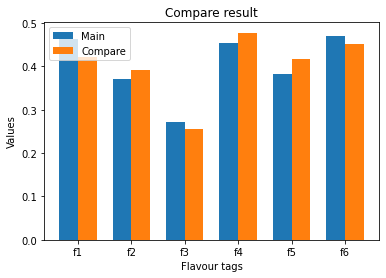

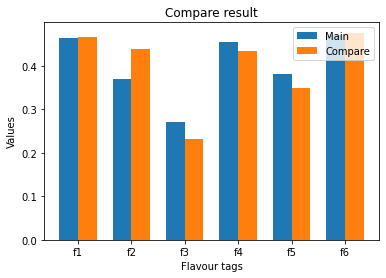

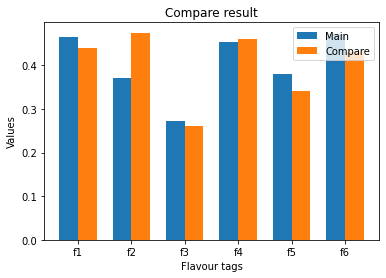

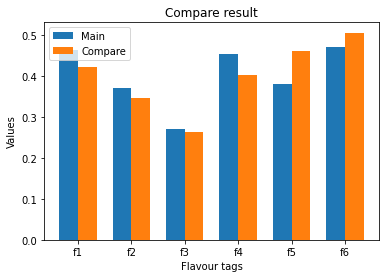

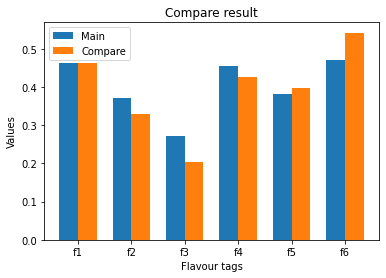

In [107]:
for item in dum:
    plot_results(entry_record, item)

## Evaluation method

In [109]:
def evaluation(df, id_entry, list_liquors):
    entry_data = np.array(df.iloc[id_entry][['f1', 'f2', 'f3',
                                             'f4', 'f5', 'f6']])
    number_liquor = len(list_liquors)
    mse = 0
    for item in list_liquors:
        e = np.subtract(np.array(item), entry_data)
        mse += (e**2)
    
    return mse.sum(), number_liquor

In [110]:
sum_mse = 0
total_number_liquor = 0

for i in df_filling.index.values:
    list_liquors = find_similarities(df_filling, i, del_sequel=False, verbose=False)
    mse, number_liquor = evaluation(df_filling, i, list_liquors)
    sum_mse += mse
    total_number_liquor += number_liquor

print('Mean square error ---- {}'.format(sum_mse))
print('Total number records ---- {}'.format(total_number_liquor))
print('Mean Loss ---- {}'.format(sum_mse/total_number_liquor))

Mean square error ---- 110.34612371017352
Total number records ---- 4145
Mean Loss ---- 0.026621501498232454


In [294]:
# df_filling.index.values

In [281]:
# import time

# start = time.time()
# loaded_model = pickle.load(open('knn_pickle_file', 'rb'))
# print(time.time() - start)

In [146]:
# df_initial[df_initial.f1.duplicated() & df_initial.flavour_tags.duplicated()]